                                                                                                    Author: Jahanavi Desai 
                                                                                                    Course: Intro to Machine Learning
                                                                                                    Date: May 27th, 2024

# Predicting the Fat Level of Different Cheeses in Canada

### Foreword

This notebook will be showing some great machine learning algorithms and exploratory data analysis for the subset of `Cheese Dataset Directory of Canada` dataset. The data were obtain from Kaggle and follows an Open Government Licence (Canada).

### Introduction
In this project, we aim to predict the fat level (category) of different types of Canadian cheeses using various features from the provided dataset. This is a classification problem our target variable is the fat level. Accurate predictions can benefit cheese manufacturers and consumers by providing insights into cheese content and help in product selection.
### Goal
Predict the fat level category of cheeses using different machine learning models and finding the best one to get the accurate prediction.
### Significance
Understanding the fat proportion is necessary for dietary purposes and food manufacturing standards.
### Problem Type
This is a classification problem since the target variable (fat-level) is categorical as it classes into 2 values 0 and 1.

In [1]:
#Importing the neccessary libraries for our project:

import os
from hashlib import sha1
import pandas as pd
import numpy as np
import string
import altair as alt
import graphviz

from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer, Normalizer, OneHotEncoder, StandardScaler,OrdinalEncoder, normalize, scale
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_score, f1_score

from scipy.stats import lognorm, loguniform, randint

import warnings
warnings.filterwarnings('ignore')

## Dataset Description

The dataset contains various attributes about different types of Canadian cheeses, including:

| Column                | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| ManufacturerProvCode  | Code representing the province where the cheese is manufactured             |
| ManufacturingTypeEn   | Type of manufacturing process used for the cheese                           |
| MoisturePercent       | Percentage of moisture content in the cheese                                |
| FlavourEn             | Description of the cheese's flavor (can be transformed with CountVectorizer)|
| CharacteristicsEn     | Characteristics of the cheese (can be transformed with CountVectorizer)     |
| Organic               | Whether the cheese is organic (Yes/No)                                      |
| CategoryTypeEn        | Category of the cheese                                                      |
| MilkTypeEn            | Type of milk used to produce the cheese                                     |
| MilkTreatmentTypeEn   | Type of treatment the milk underwent                                        |
| RindTypeEn            | Type of rind on the cheese (not used in this analysis)                      |
| CheeseName            | Name of the cheese (can be transformed with CountVectorizer)                |
| FatLevel              | The fat level of the cheese (target variable)                               |


In [2]:
#Importing and reading the Data Frame
cheese = pd.read_csv('data/cheese_data.csv')
cheese.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


Here we have some columns that we don't need for our project so we will drop it

In [3]:
cheese_df = cheese.drop(columns=['CheeseId','RindTypeEn'])
cheese_df.head(2)

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),lower fat
1,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,lower fat


Before we do any data manipulation or EDA we will just split the data to avoid violating the Golden Rule

In [4]:
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=123)

### We will do our Exploratory Data Analysis on our train data

In [5]:
cheese_df.shape

(1042, 11)

In [6]:
train_df.shape

(833, 11)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 482 to 1041
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       821 non-null    float64
 3   FlavourEn             637 non-null    object 
 4   CharacteristicsEn     522 non-null    object 
 5   Organic               833 non-null    int64  
 6   CategoryTypeEn        813 non-null    object 
 7   MilkTypeEn            832 non-null    object 
 8   MilkTreatmentTypeEn   781 non-null    object 
 9   CheeseName            833 non-null    object 
 10  FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 78.1+ KB


Here we can see we have 2 numeric columns and 9 categorical columns

In [8]:
# Scatter plot of Moisture Percent vs. FatLevel
scatter_plot = alt.Chart(train_df).mark_point().encode(
    x='MoisturePercent',
    y='FatLevel',
    color='FatLevel'
).properties(
    title='Moisture Percent vs Fat Level'
)
scatter_plot

alt.Chart(...)

Here we can see that higher fat level has low moist level in compared to the lower fat level cheese.

In [9]:
# Bar chart of the distribution of Fat Level
bar_chart = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('FatLevel', title='Fat level'),
    y=alt.Y('count()', title='Number of Levels')
).properties(title='Distribution of Fat Level in the data')
bar_chart

alt.Chart(...)

In [10]:
train_stats = train_df.describe(include='all')
train_stats

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
count,833,833,821.000000,637,522,833.000000,813,832,781,833,833
unique,10,3,NaN,515,446,NaN,6,8,3,830,2
top,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,Boerenkaas,lower fat
freq,635,370,NaN,48,12,NaN,271,596,648,2,548
mean,NaN,NaN,47.052741,NaN,NaN,0.091236,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,9.660351,NaN,NaN,0.288118,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,12.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,46.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [11]:
# Checking for missing values
missing_values = train_df.isnull().sum()
missing_values[missing_values > 0]

MoisturePercent         12
FlavourEn              196
CharacteristicsEn      311
CategoryTypeEn          20
MilkTypeEn               1
MilkTreatmentTypeEn     52
dtype: int64

## Challenges:

1) Here we have a big amount of missing data in some of the feature columns that needs to be fixed, also the outliers. <br>
2) Have to fix the incorrect datatypes of some columns.<br>
3) we need to do some feature transformation on categorical columns using appropriate techniques - OneHotEncoder. <br>
4) To get the best model's performance we need to fix the imbalanced between the target and the feature.

Our Evaluation Metrics:
Here for the numeric features,Mean Absolute Error (MAE)
Classification metrics for categorical feature

In [12]:
#relation of our features and the target
def plot_histogram(df,feature):
    """
    plots a histogram of a decision trees feature

    Parameters
    ----------
    feature: str
        the feature name
    Returns
    -------
    altair.vegalite.v3.api.Chart
        an Altair histogram 
    """
    histogram = alt.Chart(df).mark_bar(
        opacity=0.7).encode(
        alt.X(str(feature) + str(':O'), bin=alt.Bin(maxbins=50)),
        alt.Y('count()', stack=None),
        alt.Color('FatLevel:N')).properties(
        title= str.title(feature))
    return histogram

feature_list = train_stats.columns[:3]
figure_dict = dict()
for feature in feature_list:
    train_df = train_df.sort_values('FatLevel')
    figure_dict.update({feature:plot_histogram(train_df,feature)})
figure_panel = alt.vconcat(*figure_dict.values())
figure_panel

alt.VConcatChart(...)

Here i feel, we can see moistpercent is most related to our target FatLevel. our data is skewed towards one of the fat level  and is imbalanced,which we have balance by undersampling the majority level or oversampling the minority level.

Here we have the classification problem as our target is a categorical feature having only 2 classes. <br>

In [13]:
#lets fix the datatypes:
cheese_df['Organic'] = cheese_df['Organic'].astype(int)

In [14]:
# Define numerical and categorical features
numerical_feature = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_feature = ['Organic']

Lets fix the missing values by some preprocessing, we will use SimpleImputer to handle some null values. Making our 3 transformers for each of the feature.

As we have 2 numeric column, 1 binary numeric column and rest 8 categorical column

In [15]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler())

In [16]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [17]:
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                   OneHotEncoder(drop="if_binary", dtype=int))

In [18]:
preprocessor = make_column_transformer(
        (numeric_transformer, numerical_feature),
        (categorical_transformer, categorical_features),
        (binary_transformer, binary_feature)
)

In [19]:
X = cheese_df.drop(columns=['FatLevel','CheeseName'])
y = cheese_df['FatLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train_processed = preprocessor.fit_transform(X_train)


### Model Selection and Training
We will DummyClassifier as baseline model <br>
we will use KNN, SVC, and Logistic Regression models for testing <br>
We will perform Cross-validation for model evaluation <br>
Then we will get Training and testing accuracy scores <br>

In [40]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train_processed, y_train)
dummy_score = dummy_classifier.score(X_train_processed, y_train)
dummy_score

0.6518607442977191

In [41]:
#Here our dummy classfication shows we have around 65 percent of the accuracy.

In [34]:
models = {
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=2000)
}

for name, model in models.items():
    model_pipeline = make_pipeline(preprocessor, model)
    model_scores = cross_validate(model_pipeline, X_train, y_train, cv=5, return_train_score=True)
    print(f"\n{name} Results:")
    print("Train Accuracy:", np.mean(model_scores['train_score'].round(2)))
    print("Test Accuracy:", np.mean(model_scores['test_score'].round(2)))
    model_pipeline.fit(X_train, y_train)


KNN Results:
Train Accuracy: 0.866
Test Accuracy: 0.8200000000000001

SVC Results:
Train Accuracy: 0.836
Test Accuracy: 0.7859999999999999

Logistic Regression Results:
Train Accuracy: 0.812
Test Accuracy: 0.796


In [42]:
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  higher fat       0.73      0.53      0.62        68
   lower fat       0.80      0.91      0.85       141

    accuracy                           0.78       209
   macro avg       0.77      0.72      0.73       209
weighted avg       0.78      0.78      0.77       209



### Model Evaluation
Evaluation of each model's performance using classification metrics we have got that the KNN does the best job and our logistic regressor can give the better accuracy with set precision and f1 <br>

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [43]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 36,  32],
       [ 13, 128]])

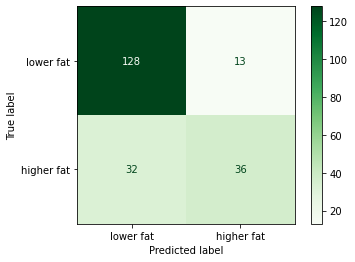

In [38]:
plot_confusion_matrix(model_pipeline, X_test, y_test, labels=['lower fat', 'higher fat'], cmap='Greens')

In [ ]:
#Its bit confusing to know how much more we can use the confusion matrix.

## Limitations of the model
This dataset may have some biasness which results in the model's performance and also the data quality and quantity. Other complex models could be used to make it most out of the predicted target.

## Conclusion Remarks
In this project, we have successfully built a model to predict the fat level category of Canadian cheeses using various features. The KNN model performed the best. The analysis shows that moisture percentage, manufacturing type, and milk type were the most important predictors of fat level.

## Resources used
* [Data Source] The data were obtained from an Open Government License
* [Data Visualization] * Inspiration for generating the plottings was taken from **sample and class notes provided by UBC and some slides**..
* Scikit-learn documentation: https://scikit-learn.org/
* Altair documentation: https://altair-viz.github.io/
* Pandas documentation: https://pandas.pydata.org/